## Data analysis and knowledge discovery - Exercise 4: Unsupervised learning

This is the template for the fourth exercise. The purpose of this exercise is to familiarize yourself with the basics of unsupervised learning by using the agglomerative hierarchical clustering algorithm to find patterns - in this case clusters of ships with the same type - in the data, and then evaluate the performance of the algorithm.


 - As in the two previous exercises, the grading scale is 0 (failed), 50 (passed) and 100 (passed with honors).
 
 - For a passing grade each part of the exercise must be done and questions answered. Some small mistakes can be tolerated but try to avoid any. All of the cells in your submitted notebook should be able to run without errors. Clean up the notebook before submitting it by deleting unnecessary cells and pieces of code for better readability.

 - Remember to comment your code to explain how it works and what it is supposed to do (messy, uncommented and badly written code may contribute to a failing grade).
 
 - Answer the questions asked in the assignments in the markdown cells below the code cells.

 - For doing both the exercise and the optional bonus task sufficiently well, you will be awarded one bonus point (passed with honors).
 

### Import all the libraries etc. you need

In [ ]:
from google.colab import files
import pandas as pd
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, pairwise_distances
from sklearn.metrics.cluster import adjusted_rand_score, contingency_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Read the data

- Download the exercise 4 data from exercise 4 tab in the Moodle page of this course.
- Read the ship data from the csv file into a Pandas dataframe.
- This file is already cleaned of outliers and missing values etc. Normally data cleaning is an important part of unsupervised learning, but since it has already been done in the previous exercises, we can start this one with already clean data.

In [ ]:
# To download the data
uploaded = files.upload()
# To read the data into the Pandas DataFrame
shipframe = pd.read_csv('shipdata2021_ex4.txt')
# Let's see what the dataframe contains
shipframe
# Seems good to move on

Saving shipdata2021_ex4.txt to shipdata2021_ex4.txt


,MMSI,Speed,COG,Destination,Ship_type,Gross_tonnage,Length,Breadth
0,212209000,10.1377,64.3074,Hamina,Cargo,3416,94.91,15.34
1,212436000,13.5256,77.0755,Hamina,Tanker,6280,116.90,18.00
2,219082000,9.9416,74.6762,Hamina,Tanker,9980,141.20,21.90
3,219083000,11.6038,74.7529,Hamina,Tanker,9980,141.20,21.60
4,219426000,11.9203,56.3253,Hamina,Tanker,3219,99.90,15.00
...,...,...,...,...,...,...,...,...
129,273374820,10.0396,74.6253,Vysotsk,Tanker,4979,139.90,16.70
130,273385070,9.3507,74.5454,Vysotsk,Tanker,4979,139.90,16.94
131,273388150,9.7668,68.7159,Vysotsk,Tanker,5075,140.85,16.86
132,636092755,11.1554,73.7013,Vysotsk,Tanker,23240,183.00,27.37


### Part 1: Preprocess and visualize the data

 - Use "Speed", "COG", "Length", and "Gross_tonnage" as features for this exercise. You will also need the 'Ship_type' -column later to be used as labels for evaluating the performance of the clustering algorithm.
  
 - Perform z-score standardization on the features to ensure that all features have the same scale.
 
 - Project the data to two dimensions by using principal component analysis (PCA) and visualize the resulting two-dimensional data in a scatter plot. Don't color the scatter plot yet. Can you guess where the different ship types are in the scatter plot? Don't worry if they're hard to see.
 
 - The set of features used in this exercise is not necessarily the most sensible from the point of view of real life maritime data-analysis, but rather has been chosen in an ad-hoc manner for the purpose of designing this exercise with a certain level of clustering performance. Consider the features given for now.

,Speed,COG,Length,Gross_tonnage
0,-0.161299,-0.890846,-0.564071,-0.539572
1,1.580209,-0.076393,-0.180767,-0.383440
2,-0.262102,-0.229440,0.242802,-0.181734
3,0.592331,-0.224547,0.242802,-0.181734
4,0.755024,-1.400010,-0.477091,-0.550311


The loadings of the original attributes:


,PC1,PC2
Speed,0.342034,-0.472969
COG,-0.143109,0.821038
Length,0.669656,0.141632
Gross_tonnage,0.643501,0.286596


Principal components:


,PC1,PC2
0,-0.652630,-0.889659
1,0.183623,-0.945607
2,-0.011165,-0.082108
3,0.280380,-0.482212
4,-0.215014,-1.731853


Total explained variance of these two components is 78.11408916879469


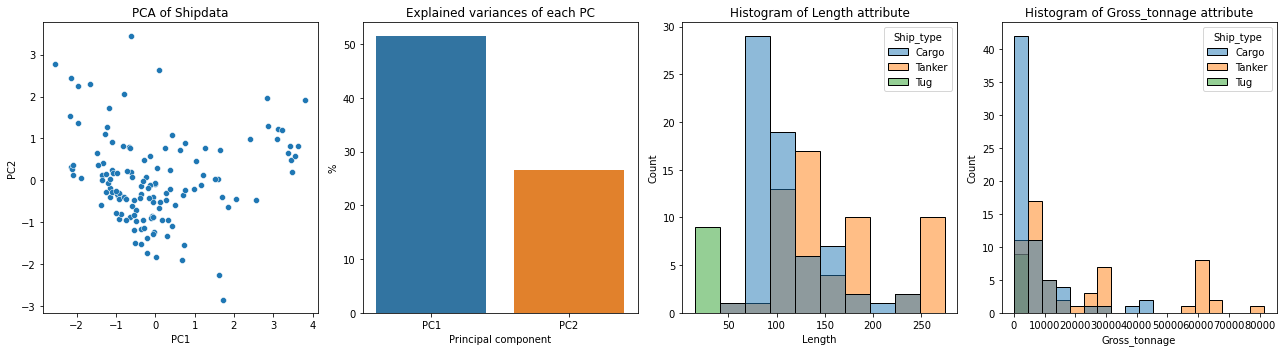

In [ ]:
# First - ship types into an array for later use
ship_types = shipframe['Ship_type']
# =============================================================== #
# Using Speed, COG, Length and Gross_tonnage as features
# So let's start with Z score standardization to normalize the attributes
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html to compute the z score
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html to apply zscore along an axis
feature_frame = shipframe.copy()
col_names = ['Speed', 'COG', 'Length', 'Gross_tonnage']
feature_frame = feature_frame[col_names].apply(zscore)

# Display to see the results
display(feature_frame[:5]) # -> normalizing done successfully!
print('=======================================================')

# Projecting data to 2-dimension by using PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA
pca = PCA(n_components=2) # n_components=2 for 2-dimensionality
principalComponents_feature = pca.fit_transform(feature_frame) # fir_transform() for fitting the model and applying dimensionality reduction
# Creating a new dataframe to have the PCs
# PC1 for 1st principal component and PC2 for 2nd principal component
principal_fframe = pd.DataFrame(principalComponents_feature, columns=['PC1', 'PC2'])

pca_ratio = pca.explained_variance_ratio_ # saving the ratio and components for barplot
total_var = pca.explained_variance_ratio_.sum()*100 # calculating the total variance

## Extra: Since it would be nice to understand the contribution of the original attributes (Speed, COG, Length, Gross_tonnage) to the PCs so let's find out the loadings of each
loadings = pca.components_.T*np.sqrt(pca.explained_variance_)
# Let's make a dataframe of loadings to understand them better
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_frame.columns)
print('The loadings of the original attributes:')
display(loadings_df)

# Again, let's see what we got
print('Principal components:')
display(principal_fframe[:5])
print('Total explained variance of these two components is', total_var)
print('=======================================================')

# Subplotting scatterplot and barplot
fig, ax = plt.subplots(1,4, figsize=(18,5))
# Visualizing the resulting 2-dimensional data in a scatter plot
sns.scatterplot(x=principal_fframe['PC1'], y=principal_fframe['PC2'], ax=ax[0])
ax[0].set(title='PCA of Shipdata')

# Checking the values of PC1 and PC2 since the PC1 should have the most of the data compressed into it by using barplot to analyze the distribution
sns.barplot(x=['PC1', 'PC2'], y=pca_ratio*100, ax=ax[1])
ax[1].set(title='Explained variances of each PC', xlabel='Principal component', ylabel='%')

# Quick histogram to visualize the distributions of ship types length
sns.histplot(shipframe, x='Length', hue='Ship_type', ax=ax[2])
ax[2].set(title='Histogram of Length attribute')

sns.histplot(shipframe, x='Gross_tonnage', hue='Ship_type', ax=ax[3])
ax[3].set(title='Histogram of Gross_tonnage attribute')

sns.axes_style("darkgrid")
fig.tight_layout()
plt.show()
# So the PC1 seems to have the most of the data as it has over 50% of it

####  Part 1 : Answers here:

<font color = red>From the PCA loadings it can see that attributes *Gross_tonnage* and *Length* have the most weight contributing to the PC1 and *COG* actually has the most weight contributing to the PC2. The distributions of Length and Gross_tonnage are visualized with histograms above.

<font color = red>So based on that I'd say that since the Tug vessels were the tiniest ones, they are on the left side of the scatterplot. Tankers and Cargos could be spread out the most since their sizes variance more. I would guess that Cargos are located in the middle and Tankers more right sided since among the Tankers there were the biggest vessels as shown in the previous exercise sets. I would also say, based on the histograms, the Cargos and Tankers are quite mixed in the middle.

<font color = red>As for the sake of repetition, according to the references below, The Principal Component Analysis (PCA) is about computing principal components (PCs) and using them to perform changes of basis on the data. The *eigenvectors* are the direction of the ax where there is the most variance. The *eigenvalues* on the other hand are the amount of variance carried in each eigenvector. The *loadings* are the coefficients of the linear combination of the original variables from which PCs are constructed. 

<font color = red>So, the first principal component ($PC_1$) can be defined as

\begin{equation}
PC_1 = a_{11}X_1 + a_{12}X_2 + a_{13}X_3 + .... + a_{1p}X_p,
\end{equation}

<font color = red>where $X_1, X_2, ..., X_p$ are the original variables and $a_{11}, a_{12}, ..., a_{1p}$ the weigths which can be also called as loadings since they describe how much each original variable $X_1, X_2, ..., X_p$ contributes to, in this case, $PC_1$. In matrix notations, we can define $PC_1$ simply as 

\begin{equation}
PC_1 = a_1^TX
\end{equation}

<font color = red>and actually the total transformation of the original variables to the principal components as

\begin{equation}
PC = XA,
\end{equation}

<font color = red>where the rows of $p\times p$ matrix $A$ are the *eigenvectors* which describes the orientation of the PCs relative to the original variables. The elements of an eigenvector are the loadings $a_{ij}$ which are within the particular row of the matrix $A$. Large loadings implies that this particular original variable has a strong relationship with a PC. The sign shows if they are positively or negatively correlated. Here we get back to the start where I guessed where the ships are located in the scatterplot. The loadings of Length (0.669656) and Gross_tonnage (0.643501) among the PC1 and the loading of COG (0.821038) seem to be positively correlated meaning these two variables move in the same direction.

-------

Centellegher, S. 2020. How to compute PCA loadings and the loading matrix with scikit-learn. https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html (accessed: 9.11.2021)

Wikipedia. 2021. Principal component analysis. https://en.wikipedia.org/wiki/Principal_component_analysis (accessed: 9.11.2021)

Wikipedia. 2021. Sample mean and covariance. https://en.wikipedia.org/wiki/Sample_mean_and_covariance (accessed: 9.11.2021)

### Part 2: Perform clustering on the data and evaluate the results using silhouette score

 - What is the significance of the linkage criterion in a hierarchical clustering algorithm?
 
 - Perform agglomerative hierarchical clustering on the data, trying different values for the "linkage" parameter. Use the actual number of different ship types for the number of clusters to find and default values for other parameters.
 
 - Use the z-score standardized 4-dimensional data for the clustering - not the PCA-transformed data!
 
 - Evaluate the clustering performance for each linkage criterion using a metric called "silhouette score". What does silhouette score quantify and how is it computed?

In [ ]:
# to use the actual number of different shiptypes (three) which can be calculated as
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html
ship_num = ship_types.nunique()
print('Number of different ship types is', ship_num)

# Z-score standardized 4-dimensional data for clustering as feature_frame
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# to perform the agglomerative hierarchical clustering
# n_clusters=3 for different ship types
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
# To compute the mean Silhouette Coefficient of all samples

### Linkage = 'single' ###
# uses the minimum of the distances between all observations of the two sets
single_cluster = AgglomerativeClustering(n_clusters=3, linkage='single')
# Predicting the labels of clusters
single_pred = single_cluster.fit_predict(feature_frame)
single_score = silhouette_score(feature_frame, single_pred) # euclidean distance as default
print('The mean silhouette score with Single linkage is', single_score)

### Linkage = 'complete' ###
# uses the maximum distances between all observations of the two sets
compl_cluster = AgglomerativeClustering(n_clusters=3, linkage='complete')
# Predicting the labels of clusters
compl_pred = compl_cluster.fit_predict(feature_frame)
compl_score = silhouette_score(feature_frame, compl_pred)
print('The mean silhouette score with Complete linkage is', compl_score)

### Linkage = 'average' ###
# uses the average of the distances of each observation of the two sets
avg_cluster = AgglomerativeClustering(n_clusters=3, linkage='average')
# Predicting the labels of clusters
avg_pred = avg_cluster.fit_predict(feature_frame)
avg_score = silhouette_score(feature_frame, avg_pred)
print('The mean silhouette score with Average linkage is', avg_score)

### Linkage = 'ward' ###
# minimizes the variance of the clusters being merged.
ward_cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')
# Predicting the labels of clusters
ward_pred = ward_cluster.fit_predict(feature_frame)
ward_score = silhouette_score(feature_frame, ward_pred)
print('The silhouette score with Ward linkage is', ward_score)

Number of different ship types is 3
The mean silhouette score with Single linkage is 0.29176878276068163
The mean silhouette score with Complete linkage is 0.2641065621059478
The mean silhouette score with Average linkage is 0.47142342120337954
The silhouette score with Ward linkage is 0.4397650336270209


####  Part 2 : Answers here:

<font color = red>The significance of the linkage criterion is about to determince the distance between sets of observations as a function of the pairwise distance between observations. I.e. for example in the **single linkage**, the distance of two cluster is the *minumum distance* between the members of the two clusters. Let the two clusters be $A\, (\,= {a_1, a_2, ..., a_{|A|}}$) and $B\, (\,= {b_1, b_2, ..., b_{|B|}}$) and linkage criterion $l$ so based on the different distances they can be fined as

\begin{align*}
\text{single} : l(A,B) &= min\{\,d(a,b) : a \, ϵ \, A, b \, ϵ\ B \,\} \\
\text{complete} : l(A,B) &= max\{\,d(a,b) : a \, ϵ \, A, b \, ϵ\ B \,\} \\
\text{average} : l(A,B) &= \frac{1}{|A||B|}\sum_{a ϵ A}\sum_{b ϵ B}d(a,b) \\
\text{ward}  : l(A,B) &= \sum_{x ϵ A \cup B}||x-m_{A \cup B}||_2^2-\left(\sum_{a ϵ A}||a-m_{A}||_2^2+\sum_{b ϵ B}||b-m_{B}||_2^2\right)
\end{align*}

<font color = red>Ward's criterion is for euclidean distance. So the criterions have the definitions such

> <font color = red>**single linkage** = the minimal distance between a point of A and a point of B
>
> <font color = red>**complete linkage** = the maximal distance between a point of A and a point of B
>
> <font color = red>**average linkage** = average of all distances between any point of A and any point of B or expected distance of a randomly chosen pair (a,b)
>
> <font color = red>**ward linkage** = minimizing the variance of the clusters being merged

-----

<font color = red>According to the references below and in the comments above, *silhouette score* or *silhouette coefficient* is about interpretating and validating of consistency within clusters of data. It's a measure of how well samples are clustered with similar samples. It's calculated with the mean intra-cluster distance $a$ (the average distance between i:th instance and instancees in the same cluster) and the mean nearest-cluster distance $b$ (the average distance between i:th instance and instances in other clusters) for each sample. Any distance measure can be used to calculate it such as Euclidean distance and Manhattan distance. Silhouette score of a data point $i$ can be defined as

\begin{align*}
s(i) = \frac{b(i)-a(i)}{max\{a(i), \, b(i)\}} 
\end{align*}

<font color = red>when

\begin{align*}
s(i) = \left\{ \begin{array}{rcl}
1-\frac{a(i)}{b(i)}, & \mbox{if}& a(i) < b(i)\\ 
0, & \mbox{if}& a(i) = b(i) \\
\frac{b(i)}{a(i)}-1, & \mbox{if} & a(i) > b(i)
\end{array}\right.
\end{align*}

<font color = red>So from the above it can be seen that $-1\leq s(i)\leq1$. So as $a(i)$ is a measure of how dissimilar $i$ is compared to its *own cluster*, a small value means it's well matched. On the other hand, the large $b(i)$ means $i$ is quite badly matched to its *neighbouring cluster*. Consequently when the value of $s(i)$ is close to 1, the data is appropriately clustered, but when it's close to -1, $i$ would be more appropriate when clustered in its neighbouring cluster. I.e. when the data is well clustered, instances in the same cluster are close each others and far from members of others. If the value of $s(i)$ is 0, the datum is on the border of two natural clusters. 

<font color = red> From the prints above it can be seen that the *best mean silhouette score is computed with average linkage* (0.47), which is quite close to one calculated with ward linkage (0.44). The single linkage got 0.29 and the complete one 0.26, which means the data isn't that well clustered than with the other linkages. So the method used to define the distance should be chosen carefully.

-----

Airola, A. 2021. Finding Patterns. Lecture notes. 

Bonthu H. 2021. Single-Link Hierarchical Clustering Clearly Explained. https://www.analyticsvidhya.com/blog/2021/06/single-link-hierarchical-clustering-clearly-explained/ (accessed: 10.12.2021)

Wikipedia. Hierarchical clustering. https://en.wikipedia.org/wiki/Hierarchical_clustering (accessed: 10.12.2021)

Wikipedia. Silhouette (clustering). https://en.wikipedia.org/wiki/Silhouette_(clustering) (accessed: 10.12.2021)

###  Part 3a: Compare the clusters with the true labels
 
 - If you performed the previous steps as instructed, the "average" linkage criterion should be the best performing linkage criterion (that is, with respect to the silhouette score).
 
 - Perform agglomerative hierarchical clustering on the (z-score standardized, not pca-transformed) data using the "average" linkage criterion and the number of different ship types for the number of clusters to find. Again, use default values for other parameters. Visualize the clusters with a scatterplot by performing PCA transformation to two dimensions and color the scatterplot based on the predictions produced by the clustering algorithm. 
 
 - Visualize the data again using PCA, this time coloring the scatter plot based on the true class labels. Compare the two scatter plots: how well do the clusters found by the clustering algorithm match the true classes? Place the two scatter plots so that they can easily be compared (e.g. in subplots next to each other in the same figure).
 
 - Based on the visual comparison between the clusters and true classes, would you say that the clustering was successful?
 
 - Rand score is a measure of similarity between two partitions of a set of elements - in this case true classes and clusters found by the clustering algorithm - and it is one of the most frequently used performance metrics for clustering. It is computed by considering each pair of elements in the dataset and counting pairs of elements as follows:
 
         a: number of pairs such that the elements are in the same class and in the same cluster
         b: number of pairs such that the elements are in different classes and in different clusters
         c: number of pairs such that the elements are in the same class but in different clusters
         d: number of pairs such that the elements are in different classes but in the same cluster
     
     Given a, b, c, d, the formula for rand index is:
     
         rand_index = (a+b)/(a+b+c+d).
     
- "Adjusted rand index" is corrected for chance by using maximum and expected values of rand index.

        adj_rand_index = (rand_index - expected_rand_index) / (max_rand_index - expected_rand_index)
 
- For an objective evaluation of the clustering, compute the adjusted rand score (use the scikit-learn implementation) using the true labels and the labels predicted by clustering algorithm. How do you interpret the result?
 
- If the results seem unimpressive, don't get discouraged - clustering "real life" data sets is a difficult task, and a low rand score does not necessarily mean that you have made a mistake.

,PC1,PC2,cluster
0,-0.652630,-0.889659,0
1,0.183623,-0.945607,0
2,-0.011165,-0.082108,0
3,0.280380,-0.482212,0
4,-0.215014,-1.731853,0


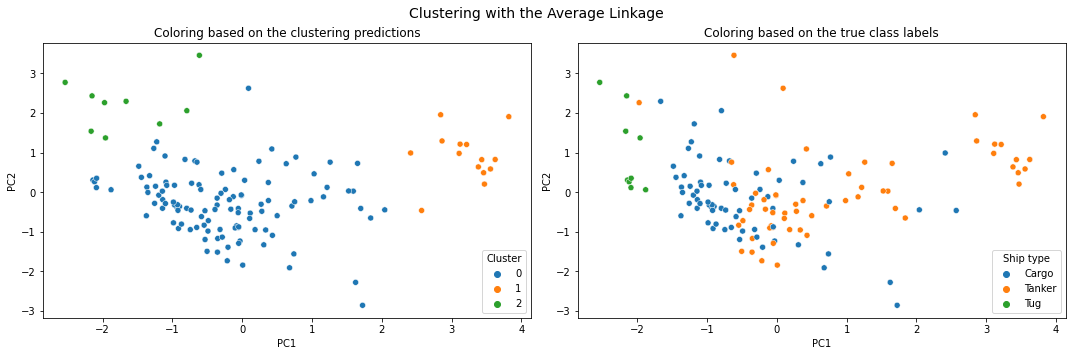

The first 10 predicted labels are [0 0 0 0 0 0 0 0 0 0]
And the first 10 true class labels are ['Cargo' 'Tanker' 'Tanker' 'Tanker' 'Tanker' 'Tanker' 'Cargo' 'Cargo'
 'Cargo' 'Tanker']
The adjusted rand score is 0.0840261353047265
and the rand index for curiousity 0.5192458758837392


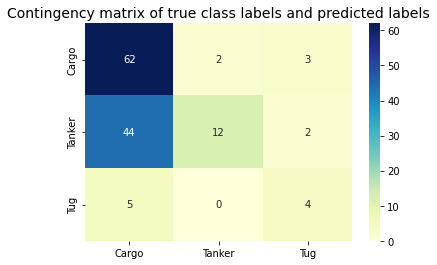

In [ ]:
## "Agglomerative hierarchical clustering on the data using the "average" linkage criterion and the number of different ship types for the number of clusters to find"
# So as previously done we do such clustering as

# Fitting the clustering from features
cluster = AgglomerativeClustering(n_clusters=3, linkage='average').fit(feature_frame) # 3 for different ship types
# PCA as one liner
principal_comps = PCA(2).fit_transform(feature_frame)
# Making the data frame out of the performed PCA and its PCs
pc_frame = pd.DataFrame(principal_comps, columns=['PC1', 'PC2'])

# Placing the label into the PC dataframe
pc_frame['cluster'] = pd.Categorical(cluster.labels_)
# So now we have the PCs and the labels in one dataframe as
display(pc_frame[:5]) # first 5 row only
print('=======================================================')

## "Visualize the clusters with a scatterplot by performing PCA transformation to two dimensions and color the scatterplot based on the predictions produced by the clustering algorithm. "
## "Visualize the data again using PCA, this time coloring the scatter plot based on the true class labels."


# So let's plot both (clusters and true class labels) to see the results
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', hue='cluster', ax=ax[0]) # cluster colored
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', hue=ship_types, ax=ax[1])

# Let's do some titling for the sake of clarity 
fig.suptitle('Clustering with the Average Linkage', size=14)
ax[0].set_title('Coloring based on the clustering predictions')
ax[1].set_title('Coloring based on the true class labels')

# And some legend adjusting
ax[0].legend(loc='lower right', title='Cluster')
ax[1].legend(loc='lower right', title='Ship type')

fig.tight_layout() # nice clean plot adjusting
fig.subplots_adjust(top=0.88) # adjusting main title
plt.show()
print('=======================================================')
print('The first 10 predicted labels are', cluster.labels_[:10]) # only 0s for Cargo - ouch
print('And the first 10 true class labels are', ship_types[:10].to_numpy()) # to_numpy() for array-like print

## "For an objective evaluation of the clustering, compute the adjusted rand score (use the scikit-learn implementation) using the true labels and the labels predicted by clustering algorithm."
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
# to get the rand index adjusted for chance. Parameters: (<labels_true>, <labels_pred>)
# Then the adjusted rand score is
print('The adjusted rand score is', adjusted_rand_score(ship_types, cluster.labels_))
print('and the rand index for curiousity', rand_score(ship_types, cluster.labels_))
print('=======================================================')

# For the curiousity let's build a contingency matrix to describe the relationship between true class and predicted labels
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cluster.contingency_matrix.html
# parameters as (<labels_true>, <labels_pred>)
cm = contingency_matrix(ship_types, cluster.labels_)
# To get the contingency matrix in a fine-looking heatmap
ax = sns.heatmap(cm, cmap="YlGnBu", annot=True, yticklabels=['Cargo', 'Tanker', 'Tug'], xticklabels=['Cargo', 'Tanker', 'Tug'])
ax.set_title('Contingency matrix of true class labels and predicted labels', size=14)
plt.show()

####  Part 3a : Answers here:

<font color = red >When comparing the scatterplots I'm not impressed about the performance of clustering. For example as there are only nine (9) Tugs in the data set, only four (4) of them were predicted truly with the Agglomerative clustering. Other five (5) were predicted either as Cargos or as Tankers. And as I tried to guess the right ship types in the previous exercise 1, I was true when I pondered if Cargos and Tankers are well mixed "in the middle". However, all the middle ships are predicted as Cargos as there are more numbers of them than Tankers. So, only true predicted Tankers are on the right side of the scatterplot, even though there are many others elsewhere. 

<font color = red >*Rand index* (RI) was described above but I want to include some more information about it for the sake of learning. As before told, RI is a measure of the similarity between two partitions of a set of elements (in our case, between true class labels and predicted labels).

<font color = red >RI ($R$) can be defined as (as shown above)

\begin{equation}
R = \frac{a+b}{a+b+c+d} = \frac{a+b}{n \choose 2},
\end{equation}

<font color = red >where $a+b$ refers to the number of agreements between two partitions and $c+d$ to the number of disagreements between these partitions. So, since the denominator is the total number of pairs $a+b+c+d$, RI actually is about *the frequency of occurrence of agreements over the total pairs*. 

<font color = red >The major problem among RI is that the expected value of two partition doesn't take a constant value. In many clustering scenarios, the number of clusters or the size distribution of these clusters vary alot. So to respond to the problem, RI is adjusted for the chance grouping of elements, which is called as *the adjusted rand index* (ARI). Out of the partitions we can define a *contingency table* which is a display format used to analyse and record the relationship between two or more categorical variables. The table of two partitions $X$ and $Y$ can be visualized as

\begin{array}{c|cc|c}
\text{Number of pairs}  &  \text{In the same cluster} & \text{In different clusters} & \text{Sums} \\ \hline
\text{In the same cluster}    & \text{Hit (a)} & \text{False alarm (b)} & \text{a+b} \\ 
\text{In different clusters}  & \text{Miss (c)}  & \text{Correct non-event (d)} & \text{c+d} \\ \hline
Sums  & a+c & b+d  & M= {n \choose 2} \\  
\end{array}

<font color = red >So based on the above, let $X$ and $Y$ are the two partitions with multiple clusters inside. Then let $n_{ij}$ be the number of elements that are in both cluster $x_i$ and cluster $y_i$. $N$ is the total number of data points in the data set. Here we get the contingency table formed as

\begin{array}{c|cccc|c}
\text{Class} & X_1 & X_2 & \cdots & X_s & \text{Sums} \\ \hline
Y_1 & n_{11} & n_{12} & \cdots & n_{1s} & a_1 \\
Y_2 & n_{21} & n_{22} & \cdots & n_{2s} & a_2 \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
Y_r & n_{r1} & n_{r2} & \cdots & n_{rs} & a_r \\ \hline
\text{Sums} & b_1 & b_2 & \cdots & b_s & N
\end{array}

<font color = red > The contingency table can help to calculate the ARI coefficients, tho scikit-learn has a simple method `sklearn.metrics.adjusted_rand_score` to calculate this right away. ARI is calculated as follows:

\begin{equation}
ARI = \frac{\text{RI} - \text{Expected RI}}{\text{Max RI} - \text{Expected RI}},
\end{equation}

<font color = red >which we can write more mathematically with the notations of the contingency table as

\begin{equation}
ARI = \frac{\sum_{ij} {n_{ij} \choose 2} - \left[ \sum_{i} {a_{i} \choose 2}\sum_{j} {b_{j} \choose 2} \right] /{n \choose 2}}
{\frac{1}{2}\left[ \sum_{i} {a_{i} \choose 2}+\sum_{j} {b_{j} \choose 2} \right]- \left[ \sum_{i} {a_{i} \choose 2}\sum_{j} {b_{j} \choose 2} \right] /{n \choose 2}},
\end{equation}

<font color = red >where the values $n_{ij}, \, a_i, \, b_j$ can be found from the contingency table. 

<font color = red >I have printed the contingency table or the contingency matrix above as a heatmap with Seaborn. As it can be seen in the scatterplots, the performance of the clustering used wasn't that succesfully and its ARI value confirms it quite well - the ARI score is "only" 0.084. Given that the ARI score of 0 is the same than putting everything in random buckets, our score is quite bad. ARI is interpreted as follows:

>  <font color = red>Excellent recovery: $\text{ARI} \geq 0.90$
>
>  <font color = red>Good recovery: $0.80 \leq \text{ARI} < 0.90$
>
>  <font color = red>Moderate recovery: $0.65 \leq \text{ARI} < 0.80$
>
>  <font color = red>Poor recovery: $\text{ARI} < 0.65$

<font color = red >So next, even though we have the method to do this, let's try to calculate them manually for curiousity. We've got the needed values in the contingency table above so let's do the math in here. But before that, we can see from the formula of the ARI score that we can extract three different parts out of it. Let's simplify the calculations and calculate the parts separately:

\begin{align*}
\text{1.} \sum_{ij} {n_{ij} \choose 2} &= {62 \choose 2} + {2 \choose 2} + {3 \choose 2} + {44 \choose 2} + {12 \choose 2} + {2 \choose 2} + {5 \choose 2} + {0 \choose 2} + {4 \choose 2} \\ &= 1891 + 1 + 3 + 946 + 66 + 1 + 10 + 0 + 6 = 2924 \\
\text{2.} \sum_{i} {a_{i} \choose 2} &= {62+2+3 \choose 2} + {44+12+2 \choose 2} + {5+0+4 \choose 2} \\ &=  2211 + 1653 + 36 = 3900 \\
\text{3.} \sum_{j} {b_{j} \choose 2} &= {62+44+5 \choose 2} + {2+12+0 \choose 2} + {3+2+4 \choose 2} \\ &= 6105 + 91 + 36 = 6232
\end{align*}

<font color = red >When $n = 132$ (the total number of all $n_{ij}$) and ${132 \choose 2} = 8646$ we got:

\begin{equation}
ARI = 
\frac{2924-[3900 \times 6232]/8646}
{\frac{1}{2}[3900 + 6232]-[3900 \times 6232]/8646} 
= \frac{\frac{162\,684}{1441}}{\frac{6\,504\,957}{2882}}
= 0.05002...
\end{equation}

<font color = red >The result is even smaller than the one calculated with a method (could the difference be explained by roundings?) As said, clustering "real life" data sets is a difficult task and this shows it quite well. Even there are 67 Cargos in total in the data set, calculating the sum of correct (62) and incorrect (49) predictions of Cargo-class, there are 111 Cargos predicted in total. Similarly, there were only 12 Tankers (out of 58) to be predicted correclty. Not to mention Tugs.

-----

Comparing Partitions.info. n.d. Clustering and Contingency Tables. http://www.comparingpartitions.info/?link=Tut14 (accessed: 12.12.2021)

CrossClustering documentation. 2019. ari: Computes the adjusted Rand index and the confidence interval,.... Rdrr.io. https://rdrr.io/cran/CrossClustering/man/ari.html (accessed: 12.12.2021)

Hasan, M.K. 2020. What is Adjusted Rand Index and How it works! https://mk-hasan.github.io/posts/2020/04/blog-post-4/ (accessed: 12.12.2021)

Wikipedia. Rand index. 2021. https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index (accessed: 12.12.2021)

###  Part 3b: Another linkage criterion
 
 - Perform the same steps as in the previous task (3a), but this time using the "complete" linkage criterion. Visualize the clusters (predicted labels vs. the real labels) and compute the adjusted rand score for the predictions.
 
 - Which linkage criterion performs better based on visual inspection and the adjusted rand score? How do the two criteria differ from each other?
 
 - Compare the formulas for adjusted rand score and silhouette score. Can you explain (briefly) why a given linkage criterion can perform relatively well with respect to one metric and badly w.r.t. the other one?

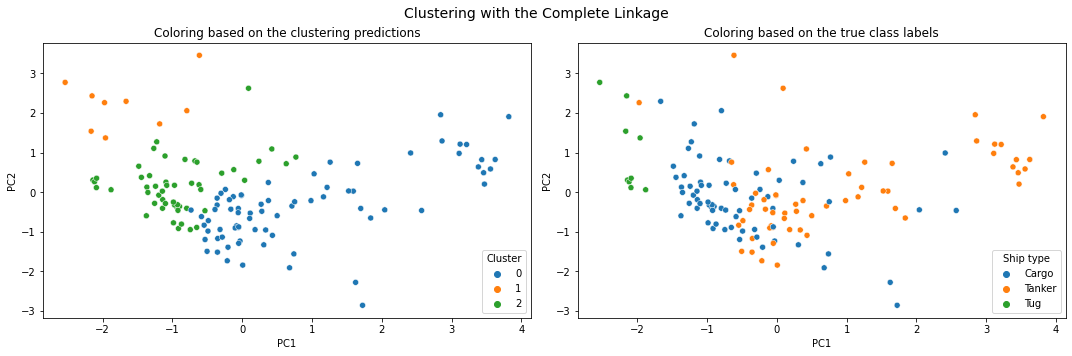

ARI score is 0.28276078550109063
RI score for curiousity is 0.6458309953989452


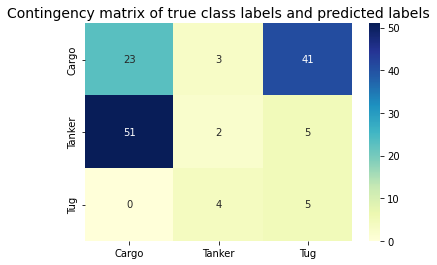

In [ ]:
# Performing the similar exercise but with the Complete linkage
# NOTE only fit (not fit_transform) to get the labels out from this variable
compl_cluster = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(feature_frame) # 3 for different ship types
# Making the data frame out of the performed PCA and its PCs
principal_comps = PCA(2).fit_transform(feature_frame)
pc_frame = pd.DataFrame(principal_comps, columns=['PC1', 'PC2'])
# Placing the label into the PC dataframe
pc_frame['cluster'] = pd.Categorical(compl_cluster.labels_)

# Scatterplotting to see the results
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', hue='cluster', ax=ax[0]) # cluster colored
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', hue=ship_types, ax=ax[1])

# Let's do some titling for the sake of clarity 
fig.suptitle('Clustering with the Complete Linkage', size=14)
ax[0].set_title('Coloring based on the clustering predictions')
ax[1].set_title('Coloring based on the true class labels')

# And some legend adjusting
ax[0].legend(loc='lower right', title='Cluster')
ax[1].legend(loc='lower right', title='Ship type')

fig.tight_layout() # nice clean plot adjusting
fig.subplots_adjust(top=0.88) # adjusting main title
plt.show()

print('================================================================')
# Then the adjusted rand score is
adj_score = adjusted_rand_score(ship_types, compl_cluster.labels_)
print('ARI score is', adj_score)
print('RI score for curiousity is', rand_score(ship_types, compl_cluster.labels_))

# Let's see the contingency matrix
cm = contingency_matrix(ship_types, compl_cluster.labels_)
# To get the contingency matrix in a fine-looking heatmap
ax = sns.heatmap(cm, cmap="YlGnBu", annot=True, yticklabels=['Cargo', 'Tanker', 'Tug'], xticklabels=['Cargo', 'Tanker', 'Tug'])
ax.set_title('Contingency matrix of true class labels and predicted labels', size=14)
plt.show()

####  Part 3b : Answers here:

<font color = red>I would really say that based on the ARI score, the complete linkage is better, but based on the visual inspection, I would say the average one is better. For the clearification, let's compute the ARI score manually as was done previously:

\begin{align*}
\text{1.} \sum_{ij} {n_{ij} \choose 2} &= {23 \choose 2} + {3 \choose 2} + {41 \choose 2} + {51 \choose 2} + {2 \choose 2} + {5 \choose 2} + {0 \choose 2} + {4 \choose 2} + {5 \choose 2} \\ &=  253 + 3 + 820 + 1275 + 1 + 10 + 0 + 6 + 10 = 2378 \\
\text{2.} \sum_{i} {a_{i} \choose 2} &= {23+3+41 \choose 2} + {51+2+5 \choose 2} + {0+4+5 \choose 2} \\ &= 2211 + 1653 + 36 = 3900 \\
\text{3.} \sum_{j} {b_{j} \choose 2} &= {23+51+0 \choose 2} + {3+2+4 \choose 2} + {41+5+5 \choose 2} \\ &= 2701 + 36 + 1275 = 4012
\end{align*}

\begin{equation}
ARI = 
\frac{2378-[3900 \times 4012]/8646}
{\frac{1}{2}[3900 + 4012]-[3900 \times 4012]/8646} 
= \frac{\frac{818\,898}{1441}}{\frac{3\,092\,796}{1441}}
= 0.26478...
\end{equation}

<font color = red>So the clustering with complete clustering really got the better ARI score than one with average clustering. The result isn't overwhelming, it's still indicating the clustering result is kinda "poor".

<font color = red>As described before, in the complete linkage, the distance between two clusters is defined as the *distance between the most distant pair of elements, one from each cluster*. On the other hand, in the average linkage, the distance between two cluster is now defined as *the average of distances between all pairs of data points, where each pair is made up of one data point from each group*.

<font color = red>Like defined before, the formulas for the ARI score ($ARI$ - also $RI$ just to get some intuition) and silhouette score ($s(i)$) are as

\begin{equation}
RI = \frac{\text{correct similar pairs} - \text{correct dissimilar pairs}}{\text{total possible pairs}} 
\end{equation}\\

\begin{equation}
ARI = \frac{\text{RI} - \text{Expected RI}}{\text{Max RI} - \text{Expected RI}}
\end{equation} \\

\begin{align*}
s(i) = \frac{\text{the mean nearest-cluster distance}-\text{the mean intra-cluster distance}}{\text{larger of these two distances}}
\end{align*}

<font color = red>and the values for each score are

> <font color = red>$\text{complete}$ : $RI = 0.65, \, \, ARI = 0.28, \, \, s(i) = 0.26$ 
>
> <font color = red>$\text{average}$ : $RI = 0.52, \, \, ARI = 0.08, \, \, s(i) = 0.47$

<font color = red>The complete linkage gets almost the same value for both scores but with the average linkage there's a huge difference between them. Could the difference be explained by the way the ARI and silhouette is defined - ARI could be seen as an external measure for clustering, but silhouette is an internal measure. Since the complete linkage is about farest distances, the performance is quite well evaluated by ARI but averaging these distances make them shorter so the average linkage can't perform that well with external measurement.

### Part 4: Plot the dendrogram

 - As the last step, plot dendrograms to visualize the merging processes.
 - For this you will need a linkage matrix - while you can extract one from a fitted AgglomerativeClustering object, it is much easier to use the scipy implementation (scipy.cluster.hierarchy.linkage).
 - Compute the linkage matrix using both average and complete linkage, and plot the dendrograms using scipy.cluster.hierarchy.dendrogram). Truncate the dendrogram so that three levels of the dendrogram tree are visible for better readability.
 - How do you interpret the dendrograms? How do they differ?

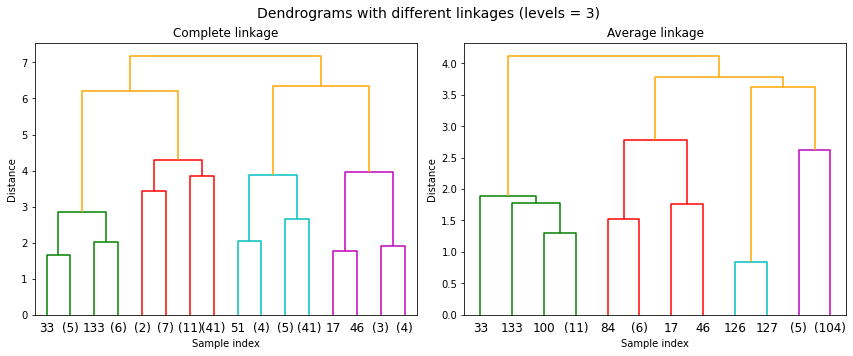

The index 126 contains:
 Speed            2.622523
COG             -1.417252
Length           0.678050
Gross_tonnage    0.110140
Name: 126, dtype: float64
and the index 127:
 Speed            3.408589
COG             -1.591304
Length           0.535815
Gross_tonnage   -0.043593
Name: 127, dtype: float64
On the other hand, the index 33 (from different cluster) contains:
 Speed           -0.772490
COG              0.138120
Length           2.557617
Gross_tonnage    3.717297
Name: 33, dtype: float64


In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
# to perform agglomerative clustering to see dendrograms
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html?highlight=dendrogram#scipy.cluster.hierarchy.dendrogram
# to plot the clustering as a dendrogram

# So first generating the linkage matrixes for each linkage, complete and average
compl_lmatrix = linkage(feature_frame, 'complete')
avg_lmatrix = linkage(feature_frame, 'average')

# Then let's plot the dendrograms
# Parameters truncate_mode='level' and p=3 to show only three levels of dendrogram tree
fig, ax = plt.subplots(1,2, figsize=(12,5))
dendrogram(compl_lmatrix, ax=ax[0], above_threshold_color='orange', truncate_mode='level', p=3, show_leaf_counts=True)
dendrogram(avg_lmatrix, ax=ax[1], above_threshold_color='orange', truncate_mode='level', p=3)

# Some titling
fig.suptitle('Dendrograms with different linkages (levels = 3)', size=14)
ax[0].set(title='Complete linkage', xlabel='Sample index', ylabel='Distance')
ax[1].set(title='Average linkage', xlabel='Sample index', ylabel='Distance')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

print("=========================================================")
# For curiousity, in the average linkage there is seen that indexes 126 and 127 are really similar
# So let's see what they are
print("The index 126 contains:\n", feature_frame.iloc[126])
print("and the index 127:\n", feature_frame.iloc[127])
print("On the other hand, the index 33 (from different cluster) contains:\n", feature_frame.iloc[33])

# So yes, indexes 126 and 127 looks more similar to me compared them both with index 33

####  Part 4 : Answers here:

<font color = red>According to the references below, the vertical (y) axis represents the distance or (dis)similarity between clusters. The vertical (x) axis, on the other hand, represents the objects and clusters. Each joining of two clusters is represented by the splitting of a vertical line into two vertical lines. The short horizontal line after splitting gives the distance between the two clusters and the height of it tells about the distance at which this label was merged into another label or cluster. I.e. horizontal lines are the cluster merges and vertical lines which clusters or labels were part of that merge which forms the new cluster. 

<font color = red>In our case, there are four different cluster since `feature_frame` contains four attributes. The different clusters are colored as <font color = green>green</font>, <font color = maroon>red</font>, <font color = blue>blue</font> and <font color = purple>purple</font>. The distances on the vertical axis differ cause of the different way they have been calculated with different linkages. Since the complete linkage is about the farest distances, it has longer distances than the average linkage which calculates the distances as average distances.

<font color = red>In the dendrogram with **complete linkage**, we can see four clusters occuring at about the same distance. The cluster sizes are in brackets () below the horizontal axis. Except the samples 33, 133, 51, 17 and 46 (the numbers which don't have the brackets), all the other samples were merged into clusters before the 3rd level of dendrogram tree. The <font color = maroon>red</font> cluster joins the <font color = green>green</font> one and the <font color = blue>blue</font> cluster joins the <font color = purple>purple</font> one, since they the <font color = maroon>red</font> and <font color = green>green</font> are more similar to each other than compared to <font color = blue>blue</font> and <font color = purple>purple</font>. The joinings are happening on the quite similar distance.

<font color = red> As we can see from the samples merged and not merged, in the **average linkage** there are more individual samples which haven't been merged into a cluster yet. There are only four mergers happened, and the cluster size are then 11, 6, 5 and 104 samples. So compared to the complete linkage, e.g. the purple cluster now has 109 samples vs 9 samples. The clusters are that way really different formed. That can also be also seen "further up" the tree since first, the <font color = blue>blue</font> and <font color = purple>purple</font> cluster joins together, then they join together with the <font color = maroon>red</font> one and lastly with the <font color = green>green</font> one. So this time the <font color = maroon>red</font> cluster is more similar with the <font color = blue>blue</font> and <font color = purple>purple</font> ones than the <font color = green>green</font> one.

<font color = red>Let's see how many samples each cluster have with the both linkage in the 3rd level of the dendrogram trees:

  $ $   |complete | average
------|---------|---------
green |  13  | 14
red | 61   | 9
blue  |  51  | 2
violet  |  9  | 109
**total** | **134** | **134**

<font color = red>The table only confirms the differences noted above.

-------
Joernhees.de. 2015. SciPy Hierarchical Clustering and Dendrogram Tutorial. https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ (accessed: 14.12.2021)

NCSS Statistical Software. n.d. Hierarchical Clustering / Dendrograms. https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Hierarchical_Clustering-Dendrograms.pdf (accessed: 14.12.2021)

Statistic How To. 2021. What is Hierarchical Clustering? https://www.statisticshowto.com/hierarchical-clustering/ (accessed: 14.12.2021)

### Part 5 (optional bonus task): Implement K-Means clustering

 - For an extra point (pass with honors i.e. 100 in the 0/50/100 grading scheme), write your <b>own implementation</b> of the K-means clustering algorithm. The bonus point will be granted for a working implementation of the algorithm. It will not be granted for e.g. merely performing clustering using the scikit-learn implementation of K-Means or an unfinished implementation.
 - Visualize the labels predicted by your K-Means implementation against the real labels and compute the adjusted rand index.
 - Compare your K-Means implementation to the scikit-learn implementation. Do you get the same results? If not, why?
 - Remember to comment your code for readability.

<font color = red> Some information about $k$-means clustering for the sake of learning before the actual code. 

<font color = red> According to the references below, **$k$-means clustering** is a simple but effective way for clustering. It aims to partition $N$ observations into $k$ clusters in which each observation belongs to the cluster with *the cluster centroid*. I.e. $k$-means clustering tries to *minimize the distance between the points within a cluster*. The goal is to group by similarity. The centroids are described as the data points in the center of a cluster. 

<font color = red> Usually, the measure of distance $d$ between the data point and cluster is **Euclidean** which can be defined as

\begin{equation}
d(p,q) = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 } 
\end{equation}

<font color = red>We can divide the $k$-means clustering into five steps as follows:
1. <font color = red>Choose the number of $k$ clusters
2. <font color = red>Select k random points from the data as centroids
3. <font color = red>Assign all the points to the closest cluster centroid
4. <font color = red>Recompute the centroids of newly formed clusters
5. <font color = red>Repeat the 3rd and 4th steps

<font color = red>There are few **stopping criterions** for $k$-means clustering such as centroids aren't changing anymore in the newly formed clusters, points are remaining in the same cluster, or maximum number of iterations are reached.

<font color = red>To find *the optimal number of $k$ clusters*, there are few methods to use. One is called as **Elbow Curve method.** The method is implemented by performing K-means clustering with different values of K (e.g. from 1 to 10), plotting these points and finding the point where the average distance from the centroid falls suddenly. This point is also called the "elbow". The other method which we can define the number of cluster with is **Silhouette analysis**. There we polt the silhouette score or silhouette coefficient for each value of K (e.g. again from 1 to 10). The average silhouette is to be calculated for the analysis. *We sure can use these two methods together for a more confident decision.*

<font color = red>For *the centroid initialization* we can sure use the **randomly selected data points** but we can also use methods like naive sharding or k-means++. **Naive sharding** (the lesser known method) algorithm depends on the calculation of a composite value reflecting all the attribute values for a particular instance. After the calculation, the composite value is used to sort the instances of the data. Once the data is sorted, it's divided horizontally into k shards. For the last thing, all the attributes from each shard is summed and their mean will be calculated. The collection of the shard attribute mean values then becomes the set of centroids. The goal for **k-means++**, on the other hand, is to spread out the initial centroid by assigning the first centroid randomly and then selecting the rest based on the maximum squared distance. This way we have centroid which are as far as possible from each other. 

----

Banerji, A. 2021. K-Mean: Getting The Optimal Number Of Clusters. https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/ (accessed: 14.12.2021)

Sharma, N. 2021. K-means Clustering Explained. https://neptune.ai/blog/k-means-clustering (accessed: 14.12.2021)

Sharma, P. 2019. The Most Comprehensive Guide to K-Means Clustering You'll Ever Need. https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/#h2_9 (accessed: 12.12.2021)

Wikipedia. 2021. k-means clustering. https://en.wikipedia.org/wiki/K-means_clustering (accessed: 12.12.2021)

Wikipedia. 2021. k-means++. https://en.wikipedia.org/wiki/K-means%2B%2B (accessed: 17.12.2021)

In [ ]:
## CLASS IMPLEMENTATIONS FOR K-MEANS CLUSTERING ##
# As we are doing the clustering from the very scratch

class K_Means:
  # Assigning the values to object properties such as k, data and centroids
  def __init__(self, k, cent_initType, max_iter = 200):
    self.k = k # cluster number
    self.max_iterations = max_iter # Max iterations to go through
    self.cent_initType = cent_initType

  # Since we need the Euclidean distance from datapoint to it's centroid, let's init method to calculate it
  # x,y for datapoints which distance needs to be computed
  def euclidean_distance(self, x, y):
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
    return np.linalg.norm(x - y, axis=0)

  # Centroid initialization methods
  # 'random' for randomly selected centroids
  # 'kmeans++' for initializing centroids in a smarter way
  def init_centroids(self, data):
    if self.cent_initType == 'random':
      # https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html
      # to return randomly permuted sequence
      return data[np.random.permutation(data.shape[0])[:self.k]]
    
    if self.cent_initType == 'kmeans++':
      ######################################################################
      # Choosing the centroids by kmeans++
      # The exact algorithm is defined as (according to Wikipedia):
      #   1. Choose one centroids randomly among the data points
      #   2. For each point, calculate distance between x and nearest centroid already chosen
      #   3. Choose new data point at random as a new centroid using a weighted probability distubution
      #       where a point is chosen with probability proportional to distance**2
      #   4. Repeat steps2 and 3 until all k centroids chosen
      #######################################################################

      # init empty centroids
      centroids = np.zeros((self.k, data.shape[1])) 
      # 1. choose a data point randomly as a first centroid
      first_cent = data[np.random.permutation(data.shape[0])[:1]]
      centroids[0] = first_cent

      # 2. Compute the euclidean distance of all other data points to the first centroid
      distances = [self.euclidean_distance(row, centroids[0]) for row in data]

      # 3. Choose new data point at random using a weighted probability
      #    Doing that, the probability for the data point to be chosen is proportional to its **squared** distance from the nearest centroid
      for i in range(1, self.k): # from 1 cause first centroid is already in the index 0
        # distance to power of 2 to calculate the weigted probabilities
        sqrt_distances = np.power(distances, 2)
        # choosing the next centroid index based on its weighted probability
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        # parameters: a= 1-array, size=output shape, replace=False can't be selected multiple times, p=probabilities with each entry in a
        next_centroid_i = np.random.choice(data.shape[0], replace=False, size=1, p=sqrt_distances / np.sum(sqrt_distances))
        centroids[i] = data[next_centroid_i]

        # When clusters still needed:
        # Next, recompute the probabilities as the minimum of the distance between the datapoint and ALL the clusters generated
        # then, update the squared distances
        new_distances = [self.euclidean_distance(row, centroids[i]) for row in data]
        # https://numpy.org/doc/stable/reference/generated/numpy.minimum.html
        # for comparing two arrays and returning a new array containing the element-wise MINIMIA
        #print('previous distances:', distances[:5])
        #print('new distances:', new_distances[:5])
        distaces = np.minimum(distances, new_distances)
      
      return centroids
      
  # For fitting the data, defining the clusters and making the predictions
  def fit(self, data):
    # The first k centroids for the first iterations for clustering
    self.centroids = self.init_centroids(data)
    self.original_cents = self.centroids.copy()
    
    # Clustering itself, max_iter to stop the clustering
    for i in range(self.max_iterations):
      self.cluster_labels = np.zeros((data.shape[0], 1))
      # Let's init the clusters
      self.clusters = {}
      for c in range(self.k):
        self.clusters[c] = [] # empty first
        
      # Let's calculate the distance between the data points and centroids
      # For each row in the data set
      iter = 0
      for row in data:
        distances = []
        min_dist = np.inf # comparing distances with this - storing always the shortest distance
        min_index = -1 # to store the index of the cluster with shortest distance
        
        #print('Row contains', row)
        for index in range(self.k):
          distance = self.euclidean_distance(row, self.centroids[index])
          distances.append(distance)
          
          #print('DISTANCE BETWEEN {} AND {} IS {}'.format(row, self.centroids[index], distance))
          # =================================================================#
          # Checking if euclidean distance is calculated right with the own method - it is
          #X = [row, self.centroids[index]]
          #print('DISTACCE CALCULATED WITH SKLEARN IS', euclidean_distances(X,X))
          # =================================================================#

          # Checking if the distance between data point and the cluster is shorter than previously checked
          if min_dist > distance:
            #print('UUSI DIST ON PIENEMPI')
            min_dist = distance
            min_index = index

        # The data point belongs to the cluster which it has the shortest distance with
        # min_dist has the shortest distance and min_index has the index of that cluster so it's easy to just append the row into the self.clusters with the min_index
        self.clusters[min_index].append(row)
        self.cluster_labels[iter] = min_index
        iter += 1

        #print('clusters now in iteration {}'.format(i), self.clusters)
        #print('labels now\n', self.cluster_labels)
        #print('right index', min_index)
        
      # After the clustering, we have datapoints in the clusters
      # Now the new centroids need to be initialized to continue the clustering
      # Let's take the mean of each already initialized centroids
      new_centroids = np.zeros((self.k,data.shape[1]))
      for cluster_i in self.clusters:
        new_centroids[cluster_i] = np.mean(self.clusters[cluster_i], axis=0)

      #print('=== uudet centroidit indeksissä {}'.format(i))
      #print('CENTROIDS BEFORE\n', self.centroids, '\nNEW\n', new_centroids)
      
      # Check if the centroids are the same - if so, leave for-loop
      # Cause no need to continue with always the same centroids :)
      if (self.centroids == new_centroids).all():
        self.iteration_endIndex = i
        break
      else:
        self.centroids = new_centroids

Some of the instances in the original dataframe:


,Speed,COG,Length,Gross_tonnage
0,-0.161299,-0.890846,-0.564071,-0.539572
1,1.580209,-0.076393,-0.180767,-0.383440
2,-0.262102,-0.229440,0.242802,-0.181734
3,0.592331,-0.224547,0.242802,-0.181734
4,0.755024,-1.400010,-0.477091,-0.550311


Some of the PCA results


,PC1,PC2
0,-0.652630,-0.889659
1,0.183623,-0.945607
2,-0.011165,-0.082108
3,0.280380,-0.482212
4,-0.215014,-1.731853


How the data really looks like after PCA before clustering:


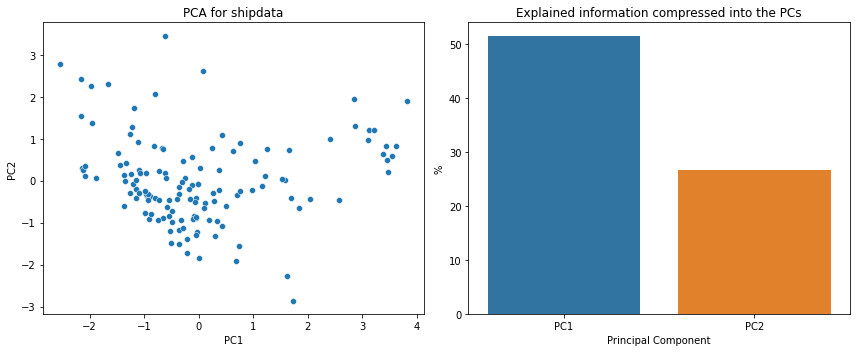

The original centroids with random selection are
 [[-0.92812585 -0.31600432]
 [ 1.59174057  0.02681474]
 [-1.10717072  0.91358005]]
The centroids after clustering are
 [[-0.21975252 -0.58553759]
 [ 2.42718559  0.56134647]
 [-1.40448203  1.02058937]]
Clustering stops at the 7th iteration
The centroids of sklearn implementation are
 [[-1.20613941  0.91839634]
 [ 2.42718559  0.56134647]
 [-0.20910341 -0.68919327]]


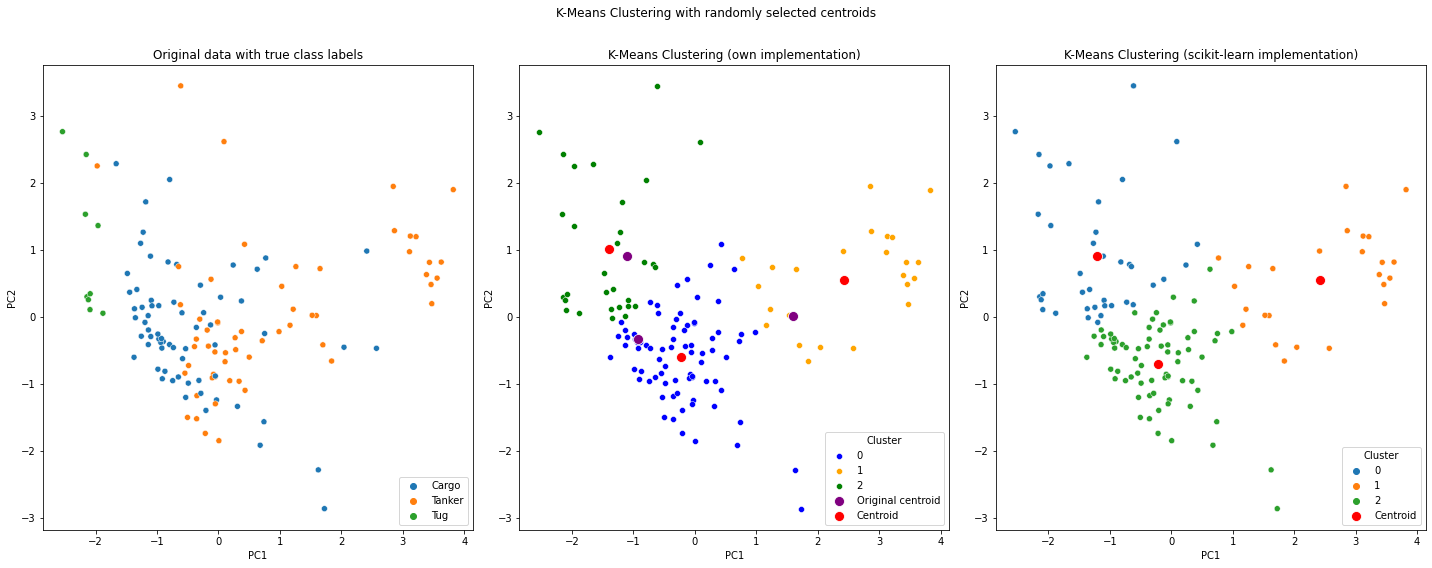

The original centroids with kmeans++ are
 [[-0.82092231  0.82690318]
 [ 3.21548233  1.20437984]
 [-0.9858735  -0.77356866]]
The centroids after clustering are
 [[-1.20444528  0.89002574]
 [ 2.47980882  0.58964856]
 [-0.17664853 -0.6882052 ]]
Clustering stops at the 3th iteration
The centroids with sklearn implementation are
 [[-1.20573989  0.86074096]
 [ 2.47980882  0.58964856]
 [-0.16122594 -0.6940172 ]]


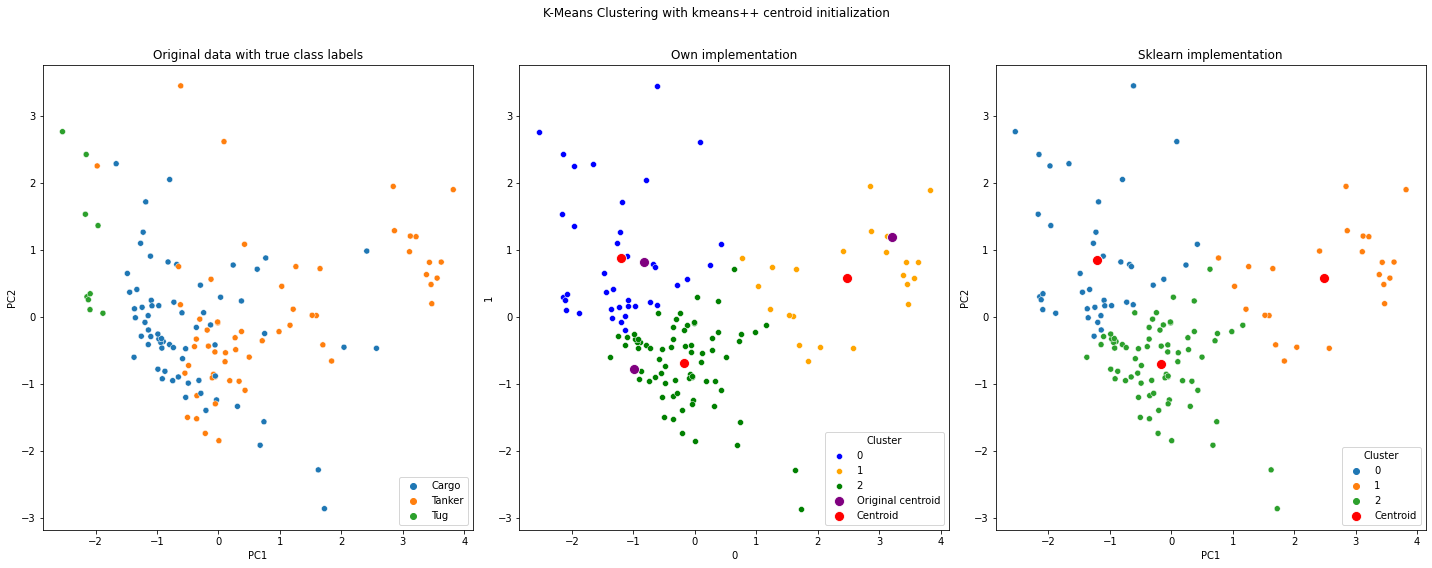

ARI of own implementation (random centroids) 0.1281034192119458
ARI of own implementation (kmeans++ centroids) 0.10068212550055479
ARI of sklearn implementation (random centroids) 0.10724062099093333
ARI of sklearn implementation (kmeans++ centroids) 0.0996490964156945


In [ ]:
# Let's do this completely from the start
# So we have the data in dataframe called feature_frame
print('Some of the instances in the original dataframe:')
display(feature_frame[:5])
# We have already normalized values for Speed, COG, Length and Gross_tonnage
# Let's do the PCA for it to get the principal components
pca = PCA(2)
pca_data = pca.fit_transform(feature_frame)
# Having it in the dataframe
pca_frame = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
print('Some of the PCA results')
display(pca_frame[:5])

testdata = pca_data[:10]
#print(testdata)

fig, ax = plt.subplots(1,2, figsize=(12,5))
# Plotting the data in scatterplot for visualizing the PCA results
print('How the data really looks like after PCA before clustering:')
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', ax=ax[0])
ax[0].set(title='PCA for shipdata')
# We can't to see how much data the PCs have so let's have the in barplot
sns.barplot(x=['PC1', 'PC2'], y=pca.explained_variance_ratio_*100, ax=ax[1])
ax[1].set(title='Explained information compressed into the PCs', ylabel='%', xlabel='Principal Component')
fig.tight_layout()
plt.show()
print("==========================================================================")
print("==========================================================================")

###############################################################################
###### OWN IMPLEMENTATION OF K-MEANS CLUSTERING ######
#### Initing the K_Means - let's have the cluster number of 3 like before
# >> 3 as cluster number
model = K_Means(3, 'random')
# Let's train the model based on the features generated by PCA
model.fit(pca_data)

# Plotting the results after clustering
# Let's have the clustering results and the original data side by side
fig, ax = plt.subplots(1,3, figsize=(20,8))
# Plotting the original data with true classes
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', hue=ship_types, ax=ax[0])
ax[0].legend(loc='lower right')

# the data points inside the clusters
# One cluster at a time to get them with different coloring
colors = ['blue', 'orange', 'green']
for i in range(len(model.clusters)):
  color = colors[i]
  cluster = pd.DataFrame.from_dict(model.clusters[i])
  sns.scatterplot(x=cluster.iloc[:, 0], y=cluster.iloc[:, 1], color=color, ax=ax[1])
# the centroids in the subplot
sns.scatterplot(x=model.original_cents[:, 0], y=model.original_cents[:, 1], color='purple', s=100, ax=ax[1])
sns.scatterplot(x=model.centroids[:, 0], y=model.centroids[:, 1], color='red', s=100, ax=ax[1])

# Some titling
ax[0].set(title='Original data with true class labels', xlabel='PC1', ylabel='PC2')
ax[1].set(title='K-Means Clustering (own implementation)', xlabel='PC1', ylabel='PC2')
# Defining the legend for the plot of K-Means
ax[1].legend(loc='lower right', title='Cluster', labels=['0', '1', '2','Original centroid','Centroid'])

##### THE SKLEARN IMPLEMENTATION OF K MEANS #####
sk_model = KMeans(n_clusters=3, init='random', max_iter=200).fit(pca_data)
# Making the pc_frame again to have a dataframe of PCA results
pc_frame = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
# Adding the cluster column for the dataframe
pc_frame['cluster'] = pd.Categorical(sk_model.labels_) 

print('The original centroids with random selection are\n', model.original_cents)
print('The centroids after clustering are\n', model.centroids)
print('Clustering stops at the {}th iteration'.format(model.iteration_endIndex))
print('The centroids of sklearn implementation are\n', sk_model.cluster_centers_)

# Plotting clusters in the scatterplot in the same subplot as the ones above
# The labels
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', hue='cluster', ax=ax[2])
# Centroids
sns.scatterplot(x=sk_model.cluster_centers_[:, 0], y=sk_model.cluster_centers_[:, 1], color='red', s=100, ax=ax[2], label='Centroid')


# Titling and defining legend
ax[2].set(title='K-Means Clustering (scikit-learn implementation)')
ax[2].legend(loc='lower right', title='Cluster')
fig.suptitle('K-Means Clustering with randomly selected centroids')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

###############################################################################
# Let's try 'kmeans++' for centroid initialization
# Own
plus_model = K_Means(3, 'kmeans++')
plus_model.fit(pca_data)
# Sklearn
plus_skmodel = KMeans(n_clusters=3, init='k-means++').fit(pca_data)
# Making the pc_frame again to have a dataframe of PCA results
plus_pc_frame = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
# Adding the cluster column for the dataframe
plus_pc_frame['cluster'] = pd.Categorical(plus_skmodel.labels_) 

print('The original centroids with kmeans++ are\n', plus_model.original_cents)
print('The centroids after clustering are\n', plus_model.centroids)
print('Clustering stops at the {}th iteration'.format(plus_model.iteration_endIndex))
print('The centroids with sklearn implementation are\n', plus_skmodel.cluster_centers_)

#### Plotting the results ####
fig, ax = plt.subplots(1,3, figsize=(20,8))
sns.scatterplot(data=pc_frame, x='PC1', y='PC2', hue=ship_types, ax=ax[0])
### Own
colors = ['blue', 'orange', 'green']
for i in range(len(plus_model.clusters)):
  color = colors[i]
  cluster = pd.DataFrame.from_dict(plus_model.clusters[i])
  sns.scatterplot(x=cluster.iloc[:, 0], y=cluster.iloc[:, 1], color=color, ax=ax[1])
# centroids
sns.scatterplot(x=plus_model.original_cents[:, 0], y=plus_model.original_cents[:, 1], color='purple', s=100, ax=ax[1])
sns.scatterplot(x=plus_model.centroids[:, 0], y=plus_model.centroids[:, 1], color='red', s=100, ax=ax[1])  

### Sklearn
sns.scatterplot(data=plus_pc_frame, x='PC1', y='PC2', hue='cluster', ax=ax[2])
# centroids
sns.scatterplot(x=plus_skmodel.cluster_centers_[:, 0], y=plus_skmodel.cluster_centers_[:, 1], color='red', s=100, ax=ax[2], label='Centroid')

# Titling and defining legends
fig.suptitle('K-Means Clustering with kmeans++ centroid initialization')
ax[0].set(title='Original data with true class labels', xlabel='PC1', ylabel='PC2')
ax[0].legend(loc='lower right')
ax[1].set(title='Own implementation')
ax[1].legend(loc='lower right', title='Cluster', labels=['0', '1', '2','Original centroid','Centroid'])
ax[2].set(title='Sklearn implementation')
ax[2].legend(loc='lower right', title='Cluster')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()
###########################################################################
# flatten to get convert np.array to a 1D array for adjusted_rand_score method
print('ARI of own implementation (random centroids)', adjusted_rand_score(ship_types, model.cluster_labels.flatten()))
print('ARI of own implementation (kmeans++ centroids)', adjusted_rand_score(ship_types, plus_model.cluster_labels.flatten()))
print('ARI of sklearn implementation (random centroids)', adjusted_rand_score(ship_types, sk_model.labels_))
print('ARI of sklearn implementation (kmeans++ centroids)', adjusted_rand_score(ship_types, plus_skmodel.labels_))

####  Part 5 : Answers here:

<font color = red> I used *random selection* and *kmeans++* to initialize the centroids. Kmeans++ can be considered as a better choise since it prefers data points that are farther from each other and avoid the close ones.

<font color = red> The ARI scores are quite similar, ranging between .09-.14. The centroids are located in the same places every time the clustering is performed, whether it's about my own implementation or Sklearn one.

<font color = red>Even tho the clusters are colored differenlty) based on the iteration time, I guess they are still the same? Could this happen because of the random centroid points and since the data points are labeled based on the closest cluster nearby? Despite this, both implementation are giving quite similar clusters, when the number of clusters is $k=3$. So the boundaries of the clusters are visualized quite similarly.

<font color = red> After all, one could say they perform clustering in fairly similar way.